In [1]:
import numpy as np
import json
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl
from numba import jit
import opt_einsum
from torch import nn
from torch.nn import functional as F

import sys
sys.path.insert(0, '../fem')
sys.path.insert(0, '../ml') 
from datasaver import load_function_list
from ManufacturedSolutionsDarcy import *
from Quadrature import *

from NGO_D import NGO

In [12]:
hparams = {'devices': [1],
           'dtype': torch.float32,
           'precision': 32,
           'optimizer': torch.optim.Adam, 
           'learning_rate': 1e-4,
           'batch_size': 100,
           'epochs': 2,
           'modeltype': 'NGO',
           'gamma_stabilization': 0,
           'data_based': False,
           'test_basis': 'B-splines',
           'trial_basis': 'B-splines',
           'quadrature': 'Gauss-Legendre',
           'Q': 100,
           'Q_L': 100,
           'h': 64,
           # 'knots_1d': np.array([0,0,0,0, 1/9, 2/9, 3/9, 4/9, 5/9, 6/9, 7/9, 8/9, 1,1,1,1]),
           'knots_1d': np.array([0,0,0,0, 0.2, 0.4, 0.6, 0.8, 1,1,1,1]),
           'UNet': True,
           'num_channels': 24,
           'kernel_sizes': [4,4,2,2],
           'bias_NLBranch': False,
           'bias_LBranch': False,
           'NLB_outputactivation': nn.Tanhshrink(),
           'scale_invariance': False,
           'symgroupavg': False}

simparams = {'d': 2}

params = {}

params['hparams'] = hparams
params['simparams'] = simparams

data_dir = '.'

In [14]:
class DataModule_Darcy_MS(pl.LightningDataModule):

    def __init__(self, data_dir, params):
        super().__init__()
        
        self.params = params
        self.data_dir = data_dir
        self.hyperparams = params['hparams']
        
    def setup(self):
        dummyNGO = NGO(self.params)
        # Generate input and output functions
        print('Generating data...')
        N_samples = 10000
        dataset = MFSetDarcy(N_samples=N_samples, d=2, l_theta_min=0.5, l_theta_max=1, l_u_min=0.25, l_u_max=0.5)
        #Discretize input functions
        print('Preprocessing data...')
        self.theta, self.theta_g, self.f, self.etab, self.etat, self.gl, self.gr = dummyNGO.discretize_input_functions(dataset.theta, dataset.f, dataset.etab, dataset.etat, dataset.gl, dataset.gr)
        self.K = torch.tensor(dummyNGO.compute_K(self.theta, self.theta_g), dtype=self.hyperparams['dtype'])
        self.d = torch.tensor(dummyNGO.compute_d(self.f, self.etab, self.etat, self.gl, self.gr), dtype=self.hyperparams['dtype'])
        #Sample x, psi and u
        self.x = np.random.uniform(0, 1, size=(N_samples,self.hyperparams['Q_L']**self.params['simparams']['d'],self.params['simparams']['d']))
        # quadrature = GaussLegendreQuadrature2D(Q=self.hyperparams['Q_L'], n_elements = dummyNGO.Trunk_test.num_basis_1d - dummyNGO.Trunk_test.p)
        # self.x = np.tile(quadrature.xi_Omega,(N_samples,1,1))
        self.psi = dummyNGO.Trunk_trial.forward(self.x.reshape((N_samples*self.hyperparams['Q_L']**self.params['simparams']['d'],self.params['simparams']['d']))).reshape((N_samples,self.hyperparams['Q_L']**self.params['simparams']['d'], self.hyperparams['h']))
        self.u = []
        for i in range(len(dataset.u)):
            u = dataset.u[i](self.x[i])
            self.u.append(u)
        self.u = np.array(self.u).reshape((N_samples,self.hyperparams['Q_L']**self.params['simparams']['d']))
        self.x = torch.tensor(np.array(self.x), dtype=self.hyperparams['dtype'])
        self.psi = torch.tensor(np.array(self.psi), dtype=self.hyperparams['dtype'])
        self.u = torch.tensor(np.array(self.u), dtype=self.hyperparams['dtype'])
        #Define dataset
        self.dataset = torch.utils.data.TensorDataset(self.K, self.d, self.psi, self.u)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.hyperparams['batch_size'], shuffle=False, num_workers=0, pin_memory=True)#, persistent_workers=True)#, prefetch_factor=2)

In [40]:
datamodule = DataModule_Darcy_MS(data_dir=data_dir, params=params)
datamodule.setup()

Generating data...
Preprocessing data...


Generating data...
Preprocessing data...
Generating data...
Preprocessing data...
Generating data...
Preprocessing data...
Generating data...
Preprocessing data...
Generating data...
Preprocessing data...
Generating data...
Preprocessing data...
Generating data...
Preprocessing data...


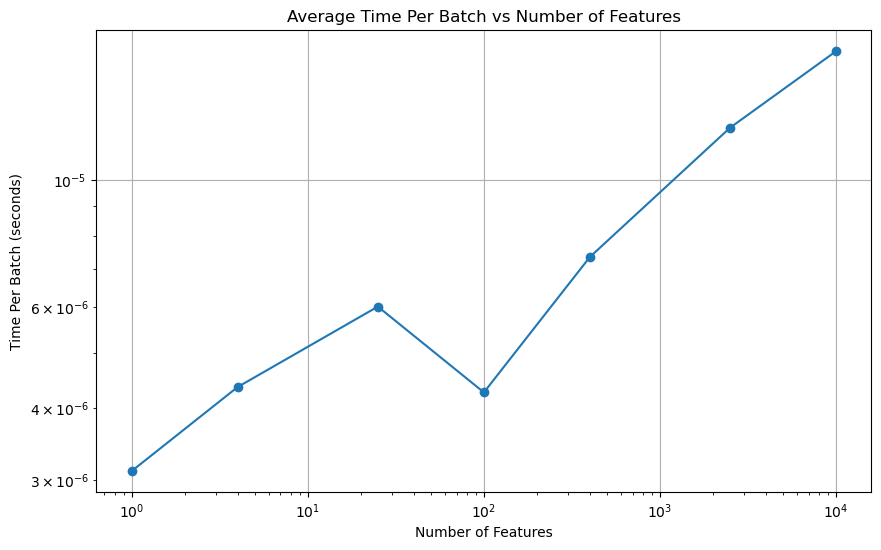

In [16]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
 
def measure_time_per_batch(num_features):
    params['hparams']['Q_L'] = num_features
    datamodule = DataModule_Darcy_MS(data_dir=data_dir, params=params)
    datamodule.setup()
    dataloader = datamodule.train_dataloader()
   
    # Measure the time taken per batch
    batch_times = []
    for batch in dataloader:
        start_time = time.time()
        K, d, psi, u = batch
        end_time = time.time()
        batch_times.append(end_time - start_time)
   
    # Return the average time per batch
    return np.average(np.array(batch_times))
 
# Number of features to test
num_features_list = [1,2,5,10,20,50,100]
 
# Measure time per batch for each number of features
times_per_batch = [measure_time_per_batch(num_features) for num_features in num_features_list]
 
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.array(num_features_list)**2, times_per_batch, marker='o')
plt.title('Average Time Per Batch vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Time Per Batch (seconds)')
plt.xscale('log')  # Logarithmic scale for better visualization
plt.yscale('log')
plt.grid(True)
plt.show()

In [36]:
import torch
from typing import List
from torch.utils.data import DataLoader, TensorDataset

# N = 1000
# X = torch.randn(N, 10)
# y = torch.randn(N, 1)
# dataset = TensorDataset(X, y)
dataset = datamodule.dataset

class TimerCallback():
    def __init__(self):
        #super().__init__()
        self.times = []
    
    def _collate_fn(self, data: List[torch.Tensor]):
        """This method takes as input a list of datapoints (as selected by the random shuffling of pytorch tensors),
        then concatenates them into a single tensor. This is the method that is called by the DataLoader to create a batch"""
        theta, f, etab, etat, gl, gr, K, d, psi, x, u = zip(*data)
        theta = torch.stack(theta)
        f = torch.stack(f)
        etat = torch.stack(etat)
        etab = torch.stack(etab)
        gl = torch.stack(gl)
        gr = torch.stack(gr)
        K = torch.stack(K)
        d = torch.stack(d)
        psi = torch.stack(psi)
        x = torch.stack(x)
        u = torch.stack(u)
        return theta, f, etab, etat, gl, gr, K, d, psi, x, u
    
    # def _collate_fn(self, data: List[torch.Tensor]):
    #     """This method takes as input a list of datapoints (as selected by the random shuffling of pytorch tensors),
    #     then concatenates them into a single tensor. This is the method that is called by the DataLoader to create a batch"""
    #     random_indices = torch.randint(low=0,high=1000, size=(100,))
    #     theta = datamodule.theta[random_indices]
    #     f = datamodule.f[random_indices]
    #     etat = datamodule.etat[random_indices]
    #     etab = datamodule.etab[random_indices]
    #     gl = datamodule.gl[random_indices]
    #     gr = datamodule.gr[random_indices]
    #     K = datamodule.K[random_indices]
    #     d = datamodule.d[random_indices]
    #     psi = datamodule.psi[random_indices]
    #     x = datamodule.x[random_indices]
    #     u = datamodule.u[random_indices]
    #     return theta, f, etab, etat, gl, gr, K, d, psi, x, u

    def collate_fn(self, batch):
        """just a wrapper around the actual collate_fn that records the time it takes to collate the batch"""
        import time
        start_time = time.perf_counter()
        out = self._collate_fn(batch)
        end_time = time.perf_counter()
        self.times.append(end_time - start_time)
        return out
    

cb = TimerCallback()

params['hparams']['Q_L'] = 100
datamodule = DataModule_Darcy_MS(data_dir=data_dir, params=params)
datamodule.setup()
dataset = datamodule.dataset

loader = DataLoader(
  dataset=dataset,
  batch_size=100,
  collate_fn=cb.collate_fn,
)



for batch in loader:
    theta, f, etab, etat, gl, gr, K, d, psi, x, u = batch
    #print(x.shape, y.shape)
    
avg_time = sum(cb.times) / len(cb.times)
print(f"avg time to collate batch: {avg_time:.6f} ms")

Generating data...
Preprocessing data...
avg time to collate batch: 0.040703 ms


In [32]:
torch.randint(low=0,high=1000, size=(100,))

tensor([194, 954, 962, 465, 164, 462, 814, 628, 692, 758, 513, 183, 573, 662,
        451, 910, 774, 801, 645, 271, 274, 233, 279, 148, 884, 845,  32, 362,
        729, 483, 236, 618, 157, 450, 129, 213, 530, 634, 515, 133, 575, 686,
        197, 559, 255, 279, 626, 541, 397, 828, 188, 390,  34, 495, 251, 767,
        953, 381, 371, 962, 546, 385,  80, 196, 325, 309, 346, 792,  61, 813,
        456, 290, 948, 940, 200, 552, 593, 589, 421, 302, 907, 898, 115, 622,
        930, 527, 179,   1, 291, 454, 508, 601, 674, 496,   1, 363,  85, 284,
        205, 336])

In [9]:
0.055726/0.002807

19.852511578197362